# Trying ensemble models to have better prediction for "Target" 

As saw in previous steps, the best models for our binary prediction of "Target" are:
- KNN, on SMOTE Dataset
- Neural Network, on SMOTE Dataset
- LightGBM, on original Dataset

Optimized parameters are found in others notebook via a GridSearch. So now, we will try to test different way to combine the prediction directly on the final prediction

After that, we will be able to combine this prediction with Failure Type prediction to obtain our final y_pred.

#### Importing librairies

In [205]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,balanced_accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler


from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import BaggingClassifier

In [4]:
!pip install lightgbm

#### Importing models

In [51]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from lightgbm import LGBMClassifier

from sklearn.linear_model import LogisticRegression


#### Loading datasets

In [17]:
#training
X_train = pd.read_csv('X_train.csv', sep=',')
X_train.columns = [c.replace(" ", "_").replace("[", "").replace("]", "") for c in X_train.columns]

y_train = pd.read_csv('y_train.csv', sep=',')
y_train_target = y_train['Target'] 
y_train_target.columns = ['Target']

#SMOTE for Target for KNN and NN models 
X_train_smote = pd.read_csv('X_train_resampled_target.csv', sep=',')
X_train_smote.columns = [c.replace(" ", "_").replace("[", "").replace("]", "") for c in X_train_smote.columns]
y_train_smote = pd.read_csv('y_train_resampled_target.csv', sep=',')
y_train_smote_target = y_train_smote['Target']
y_train_smote_target.columns = ['Target']


#testing
X_test = pd.read_csv('X_test.csv', sep=',')
X_test.columns = [c.replace(" ", "_").replace("[", "").replace("]", "") for c in X_test.columns]

y_test = pd.read_csv('y_test.csv', sep=',')
y_test_target = y_test['Target']
y_test_target.columns = ['Target']


## With a Stacking Classifier between the three models

Trying to put LightGBM as the meta model to see

In [31]:
base_models = [('knn', KNeighborsClassifier()),
               ('nn', MLPClassifier())]

lightgbm = LGBMClassifier(
            n_estimators=300,
            learning_rate=0.05, #more precise learning than 0.1
            max_depth=-1, #so that we don't set a limit
            subsample=0.8, #avoid overfitting
            colsample_bytree=0.8, #avoid overfitting 
            verbose=-1,
            class_weight='balanced')

meta_model = lightgbm

stacking_clf = StackingClassifier(estimators=base_models, final_estimator=meta_model)
stacking_clf.fit(X_train_smote, y_train_smote_target)

y_pred_target = stacking_clf.predict(X_test)


Evaluation of the Stacking

In [33]:
acc = accuracy_score(y_test_target, y_pred_target)
f1 = f1_score(y_test_target, y_pred_target)
print(f"{recall_score(y_test_target,y_pred_target)} | Accuracy: {acc:.4f} | F1-score: {f1:.4f}")


0.576271186440678 | Accuracy: 0.9113 | F1-score: 0.2776


#### Visualization of the Stacking prediction

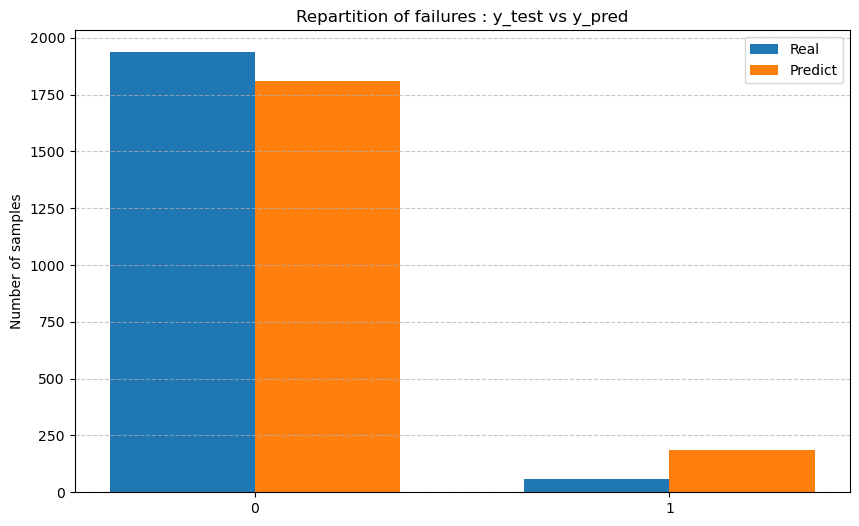

In [36]:
true_counts = pd.Series(y_test_target).value_counts().sort_index()
pred_counts = pd.Series(y_pred_target).value_counts().sort_index()

classes = sorted(set(y_test_target) | set(y_pred_target)) 

x = np.arange(len(classes))
width = 0.35

fig, ax = plt.subplots(figsize=(10,6))
ax.bar(x - width/2, [true_counts.get(c,0) for c in classes], width, label='Real')
ax.bar(x + width/2, [pred_counts.get(c,0) for c in classes], width, label='Predict')

ax.set_xticks(x)
ax.set_xticklabels(classes)
ax.set_ylabel('Number of samples')
ax.set_title('Repartition of failures : y_test vs y_pred')
ax.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

The first prediction is **not really good**: **low recall** even though accuracy is pretty high, and it predicted **too much failures**.

## Same but with Logistic Regression as a meta model (which is more usual)

In [55]:
base_models = [('knn', KNeighborsClassifier()),
               ('nn', MLPClassifier())]

logreg = LogisticRegression()

stacking_clf = StackingClassifier(estimators=base_models, final_estimator=logreg)
stacking_clf.fit(X_train_smote, y_train_smote_target)

y_pred_target = stacking_clf.predict(X_test)


Evaluation of the Stacking

In [57]:
acc = accuracy_score(y_test_target, y_pred_target)
f1 = f1_score(y_test_target, y_pred_target)
print(f"{recall_score(y_test_target,y_pred_target)} | Accuracy: {acc:.4f} | F1-score: {f1:.4f}")


0.5084745762711864 | Accuracy: 0.9163 | F1-score: 0.2643


#### Visualization of the Stacking prediction

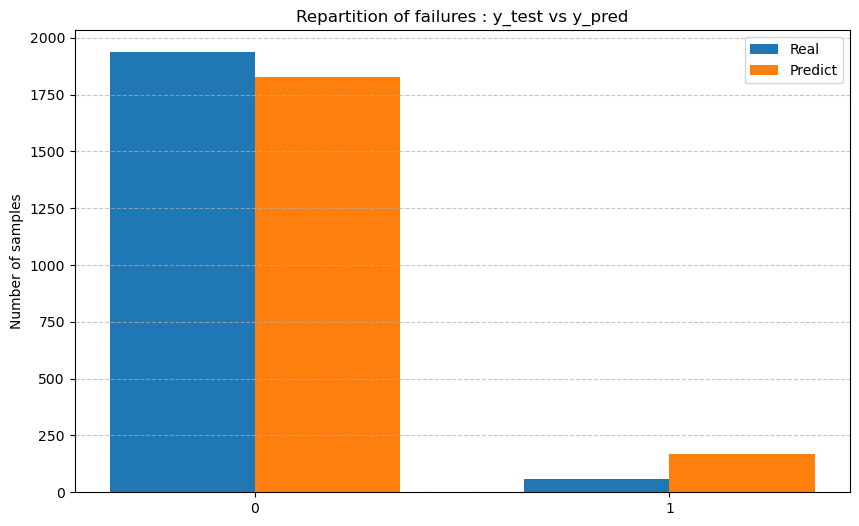

In [60]:
true_counts = pd.Series(y_test_target).value_counts().sort_index()
pred_counts = pd.Series(y_pred_target).value_counts().sort_index()

classes = sorted(set(y_test_target) | set(y_pred_target)) 

x = np.arange(len(classes))
width = 0.35

fig, ax = plt.subplots(figsize=(10,6))
ax.bar(x - width/2, [true_counts.get(c,0) for c in classes], width, label='Real')
ax.bar(x + width/2, [pred_counts.get(c,0) for c in classes], width, label='Predict')

ax.set_xticks(x)
ax.set_xticklabels(classes)
ax.set_ylabel('Number of samples')
ax.set_title('Repartition of failures : y_test vs y_pred')
ax.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Less good, so we will keep the idea of LightGBM as meta model for the next tries on Stacking.

## With a Voting Classifier only between KNN and NN

Only between KNN and NN because Voting Classifier needs to be train on one model, but LightGBM donesn't use the same dataset as KNN and NN. 
So, as a compromise, we only use KNN and NN in the Voting Classifier.

In [40]:
voting_clf = VotingClassifier(
    estimators=base_models,
    voting='hard',   
    n_jobs=-1
)

voting_clf.fit(X_train_smote, y_train_smote_target)

y_pred_target = voting_clf.predict(X_test)


Evaluation of the Voting Classifier

In [43]:
acc = accuracy_score(y_test_target, y_pred_target)
f1 = f1_score(y_test_target, y_pred_target)
print(f"{recall_score(y_test_target,y_pred_target)} | Accuracy: {acc:.4f} | F1-score: {f1:.4f}")


0.5932203389830508 | Accuracy: 0.9098 | F1-score: 0.2800


#### Visualization of the Stacking prediction

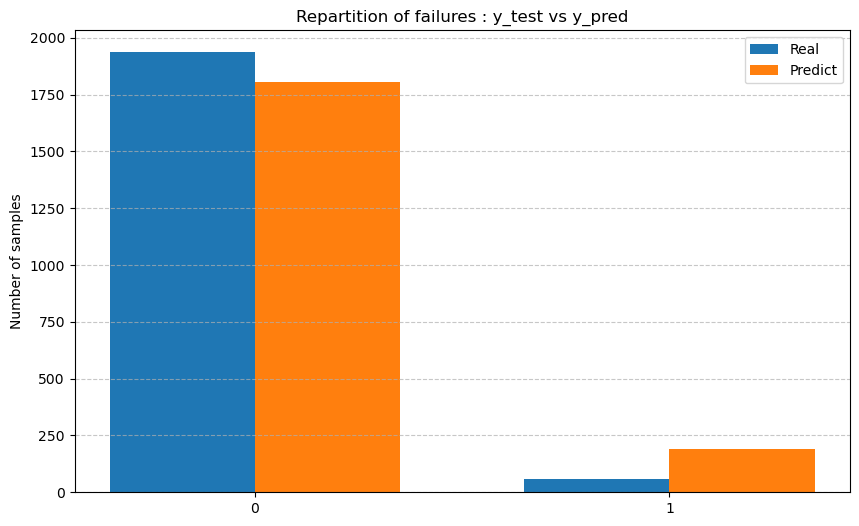

In [46]:
true_counts = pd.Series(y_test_target).value_counts().sort_index()
pred_counts = pd.Series(y_pred_target).value_counts().sort_index()

classes = sorted(set(y_test_target) | set(y_pred_target)) 

x = np.arange(len(classes))
width = 0.35

fig, ax = plt.subplots(figsize=(10,6))
ax.bar(x - width/2, [true_counts.get(c,0) for c in classes], width, label='Real')
ax.bar(x + width/2, [pred_counts.get(c,0) for c in classes], width, label='Predict')

ax.set_xticks(x)
ax.set_xticklabels(classes)
ax.set_ylabel('Number of samples')
ax.set_title('Repartition of failures : y_test vs y_pred')
ax.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Still low recall, even though a little higher

## With Bagging models then Voting Classifier

To permit the Voting between the three models, the bagging will resample the dataset within each pipeline model so the Voting prediction will occurs on the same dataset for the three models.

In [173]:
knn = KNeighborsClassifier()
nn = MLPClassifier()
lightgbm = LGBMClassifier()

bag_knn = BaggingClassifier(
    estimator=knn,
    n_estimators=10,
    max_samples=0.8,
    max_features=1.0,
    bootstrap=True,
    n_jobs=-1,
    random_state=42
)
bag_nn = BaggingClassifier(
    estimator=nn,
    n_estimators=10,
    max_samples=0.8,
    max_features=1.0,
    bootstrap=True,
    n_jobs=-1,
    random_state=42
)
bag_lightgbm = BaggingClassifier(
    estimator=lightgbm,
    n_estimators=10,
    max_samples=0.8,
    max_features=1.0,
    bootstrap=True,
    n_jobs=-1,
    random_state=42
)

print(" Training Bagging KNN...")
bag_knn.fit(X_train_smote, y_train_smote_target)

print(" Training Bagging Neural Network...")
bag_nn.fit(X_train_smote, y_train_smote_target)

print(" Training Bagging LightGBM...")
bag_lightgbm.fit(X_train, y_train_target)


voting_clf = VotingClassifier(
    estimators=[
        ('bag_knn', bag_knn),
        ('bag_nn', bag_nn),
        ('bag_lightgbm', bag_lightgbm)
    ],
    voting='hard', 
    n_jobs=-1
)

voting_clf.fit(X_train, y_train_target)

y_pred_target = voting_clf.predict(X_test)

 Training Bagging KNN...
 Training Bagging Neural Network...
 Training Bagging LightGBM...


Evaluation

In [86]:
acc = accuracy_score(y_test_target, y_pred_target)
f1 = f1_score(y_test_target, y_pred_target)
print(f"{recall_score(y_test_target,y_pred_target)} | Accuracy: {acc:.4f} | F1-score: {f1:.4f}")


0.2711864406779661 | Accuracy: 0.9779 | F1-score: 0.4211


#### Visualization of Bagging then Voting Classifier

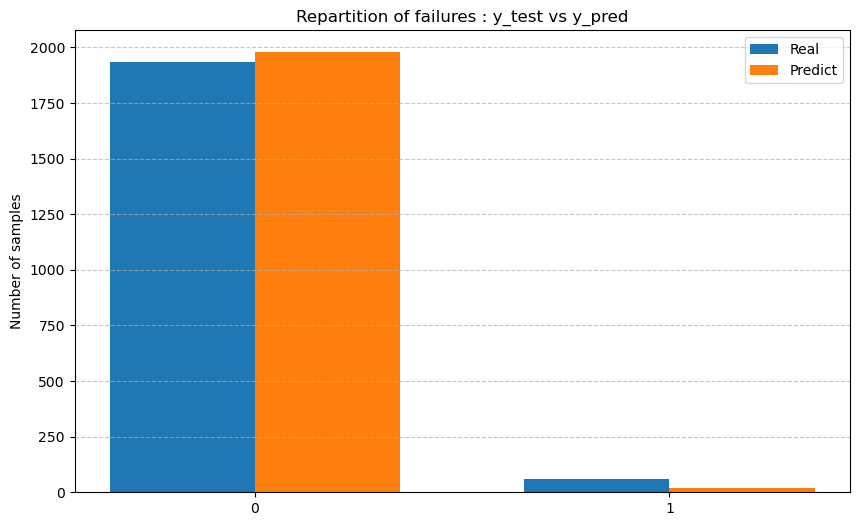

In [83]:
true_counts = pd.Series(y_test_target).value_counts().sort_index()
pred_counts = pd.Series(y_pred_target).value_counts().sort_index()

classes = sorted(set(y_test_target) | set(y_pred_target)) 

x = np.arange(len(classes))
width = 0.35

fig, ax = plt.subplots(figsize=(10,6))
ax.bar(x - width/2, [true_counts.get(c,0) for c in classes], width, label='Real')
ax.bar(x + width/2, [pred_counts.get(c,0) for c in classes], width, label='Predict')

ax.set_xticks(x)
ax.set_xticklabels(classes)
ax.set_ylabel('Number of samples')
ax.set_title('Repartition of failures : y_test vs y_pred')
ax.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Far from the result we want: worse Recall so far.

## With Bagging models then Stacking with Log Reg as meta model

In [102]:
stacking_clf = StackingClassifier(estimators=[
    ('bag_knn', bag_knn),
    ('bag_nn', bag_nn),
    ('bag_lightgbm', bag_lightgbm)], final_estimator=logreg)
stacking_clf.fit(X_train_smote, y_train_smote_target)

y_pred_target = stacking_clf.predict(X_test)

Evaluation

In [104]:
acc = accuracy_score(y_test_target, y_pred_target)
f1 = f1_score(y_test_target, y_pred_target)
print(f"{recall_score(y_test_target,y_pred_target)} | Accuracy: {acc:.4f} | F1-score: {f1:.4f}")


0.711864406779661 | Accuracy: 0.9664 | F1-score: 0.5563


#### Visualization

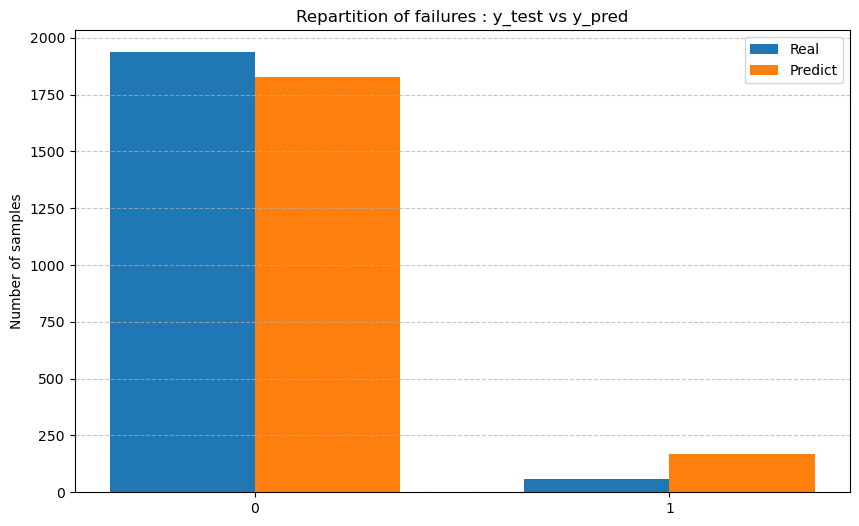

In [100]:
true_counts = pd.Series(y_test_target).value_counts().sort_index()
pred_counts = pd.Series(y_pred_target).value_counts().sort_index()

classes = sorted(set(y_test_target) | set(y_pred_target)) 

x = np.arange(len(classes))
width = 0.35

fig, ax = plt.subplots(figsize=(10,6))
ax.bar(x - width/2, [true_counts.get(c,0) for c in classes], width, label='Real')
ax.bar(x + width/2, [pred_counts.get(c,0) for c in classes], width, label='Predict')

ax.set_xticks(x)
ax.set_xticklabels(classes)
ax.set_ylabel('Number of samples')
ax.set_title('Repartition of failures : y_test vs y_pred')
ax.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

It increased the recall so **bagging then Stacking** might be a good lead.

## With Bagging models then Stacking with LightGBM as meta model

In [222]:
stacking_clf = StackingClassifier(estimators=[
    ('bag_knn', bag_knn),
    ('bag_nn', bag_nn)], final_estimator=bag_lightgbm)
stacking_clf.fit(X_train_smote, y_train_smote_target)

y_pred_target = stacking_clf.predict(X_test)

Evaluation

In [224]:
acc = accuracy_score(y_test_target, y_pred_target)
f1 = f1_score(y_test_target, y_pred_target)
print(f"{recall_score(y_test_target,y_pred_target)} | Accuracy: {acc:.4f} | F1-score: {f1:.4f}")


0.8305084745762712 | Accuracy: 0.9429 | F1-score: 0.4623


#### Visualization

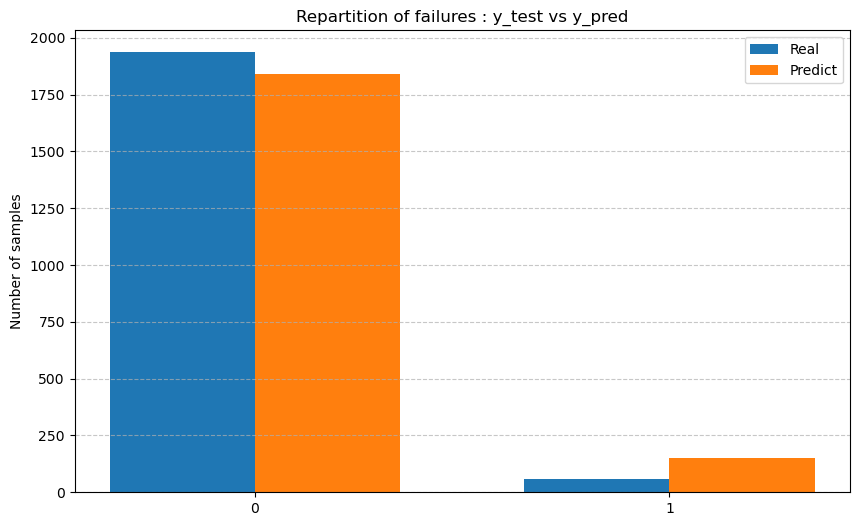

In [227]:
true_counts = pd.Series(y_test_target).value_counts().sort_index()
pred_counts = pd.Series(y_pred_target).value_counts().sort_index()

classes = sorted(set(y_test_target) | set(y_pred_target)) 

x = np.arange(len(classes))
width = 0.35

fig, ax = plt.subplots(figsize=(10,6))
ax.bar(x - width/2, [true_counts.get(c,0) for c in classes], width, label='Real')
ax.bar(x + width/2, [pred_counts.get(c,0) for c in classes], width, label='Predict')

ax.set_xticks(x)
ax.set_xticklabels(classes)
ax.set_ylabel('Number of samples')
ax.set_title('Repartition of failures : y_test vs y_pred')
ax.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [229]:
cm = confusion_matrix(y_test_target, y_pred_target)
cm

array([[1832,  104],
       [  10,   49]], dtype=int64)

This is the **highest recall** so far, so might be the best combination : **applying bagging on KNN, NN and LightGBM, then using KNN and NN as models with LightGBM as meta model for Stacking**

## Bagging models for Stacking with LightGBM as meta model, but SMOTE within pipeline of models

In [211]:
pipe_knn = Pipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('clf', KNeighborsClassifier()) #parametres a checker avec les filles gridsearch
])

pipe_nn = Pipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('clf', MLPClassifier())
])

pipe_lightgbm = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LGBMClassifier())
])

bag_knn = BaggingClassifier(
    estimator=pipe_knn,
    n_estimators=10,
    max_samples=0.8,
    max_features=1.0,
    bootstrap=True,
    n_jobs=-1,
    random_state=42
)
bag_nn = BaggingClassifier(
    estimator=pipe_nn,
    n_estimators=10,
    max_samples=0.8,
    max_features=1.0,
    bootstrap=True,
    n_jobs=-1,
    random_state=42
)
bag_lightgbm = BaggingClassifier(
    estimator=pipe_lightgbm,
    n_estimators=10,
    max_samples=0.8,
    max_features=1.0,
    bootstrap=True,
    n_jobs=-1,
    random_state=42
)

stacking_clf = StackingClassifier(estimators=[
    ('bag_knn', bag_knn),
    ('bag_nn', bag_nn)], final_estimator=bag_lightgbm)
stacking_clf.fit(X_train, y_train_target)

y_pred_target = stacking_clf.predict(X_test)

Evaluation

In [192]:
acc = accuracy_score(y_test_target, y_pred_target)
f1 = f1_score(y_test_target, y_pred_target)
print(f"{recall_score(y_test_target,y_pred_target)} | Accuracy: {acc:.4f} | F1-score: {f1:.4f}")


0.6610169491525424 | Accuracy: 0.9799 | F1-score: 0.6610


#### Visualization

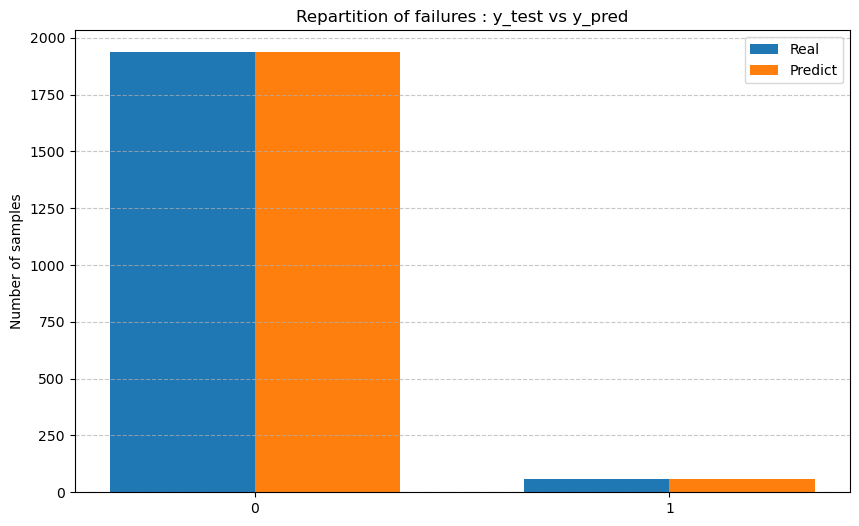

In [194]:
true_counts = pd.Series(y_test_target).value_counts().sort_index()
pred_counts = pd.Series(y_pred_target).value_counts().sort_index()

classes = sorted(set(y_test_target) | set(y_pred_target)) 

x = np.arange(len(classes))
width = 0.35

fig, ax = plt.subplots(figsize=(10,6))
ax.bar(x - width/2, [true_counts.get(c,0) for c in classes], width, label='Real')
ax.bar(x + width/2, [pred_counts.get(c,0) for c in classes], width, label='Predict')

ax.set_xticks(x)
ax.set_xticklabels(classes)
ax.set_ylabel('Number of samples')
ax.set_title('Repartition of failures : y_test vs y_pred')
ax.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [200]:
y_pred_target = pd.DataFrame.from_dict(y_pred_target)

failure_counts = y_test_target.value_counts()
failure_counts_pred = y_pred_target.value_counts()
print(f'Actual repartition: {failure_counts} VS Predicted repartition: {failure_counts_pred}')

Actual repartition: Target
0    1936
1      59
Name: count, dtype: int64 VS Predicted repartition: 0
0    1936
1      59
Name: count, dtype: int64


It is strange that the repartition is as perfect, so we print the confusion matrix to better understand:

In [213]:
cm = confusion_matrix(y_test_target, y_pred_target)
cm

array([[1916,   20],
       [  20,   39]], dtype=int64)

By doing the SMOTE within the pipeline, we make sure to apply LightGBM on the original dataset contrarly to previous prediction. 
The recall is not really high but the repartition is perfect.
However, when we print the confusion matrix, it seems that there are a lot of False Positive ad False Negative (explaining this recall score).
In our case this might no be the most appropriate prediction.

## Bagging models for Voting Classifier, but SMOTE within pipeline of models

This might be a compromise

In [215]:
smote = SMOTE(random_state=42)

pipe_knn = Pipeline([
    ('scaler', StandardScaler()),
    ('smote', smote),
    ('clf', KNeighborsClassifier()) #parametres a checker avec les filles gridsearch
])

pipe_nn = Pipeline([
    ('scaler', StandardScaler()),
    ('smote', smote),
    ('clf', MLPClassifier())
])

pipe_lightgbm = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LGBMClassifier())
])

bag_knn = BaggingClassifier(
    estimator=pipe_knn,
    n_estimators=10,
    max_samples=0.8,
    max_features=1.0,
    bootstrap=True,
    n_jobs=-1,
    random_state=42
)
bag_nn = BaggingClassifier(
    estimator=pipe_nn,
    n_estimators=10,
    max_samples=0.8,
    max_features=1.0,
    bootstrap=True,
    n_jobs=-1,
    random_state=42
)
bag_lightgbm = BaggingClassifier(
    estimator=pipe_lightgbm,
    n_estimators=10,
    max_samples=0.8,
    max_features=1.0,
    bootstrap=True,
    n_jobs=-1,
    random_state=42
)

voting_clf = VotingClassifier(
    estimators=[
        ('bag_knn', bag_knn),
        ('bag_nn', bag_nn),
        ('bag_lightgbm', bag_lightgbm)
    ],
    voting='hard', 
    n_jobs=-1
)

voting_clf.fit(X_train, y_train_target)

y_pred_target = voting_clf.predict(X_test)

Evaluation

In [139]:
acc = accuracy_score(y_test_target, y_pred_target)
f1 = f1_score(y_test_target, y_pred_target)
print(f"{recall_score(y_test_target,y_pred_target)} | Accuracy: {acc:.4f} | F1-score: {f1:.4f}")


0.8135593220338984 | Accuracy: 0.9754 | F1-score: 0.6621


#### Visualization

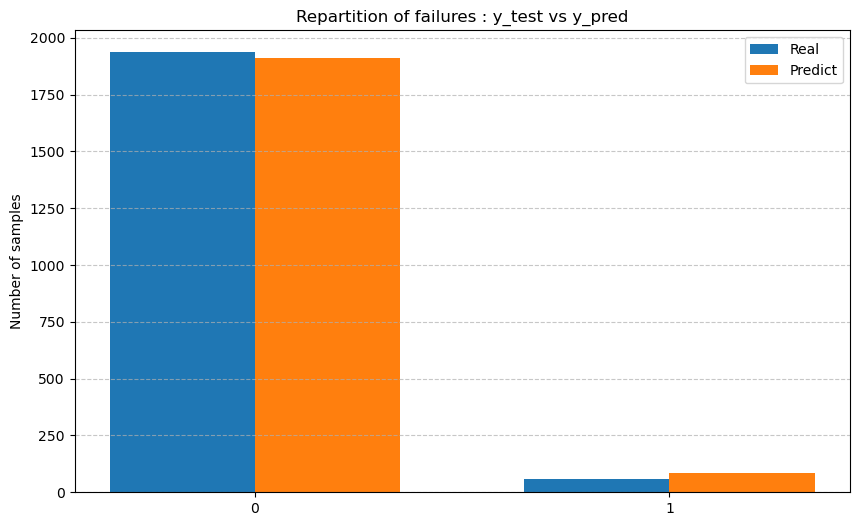

In [141]:
true_counts = pd.Series(y_test_target).value_counts().sort_index()
pred_counts = pd.Series(y_pred_target).value_counts().sort_index()

classes = sorted(set(y_test_target) | set(y_pred_target)) 

x = np.arange(len(classes))
width = 0.35

fig, ax = plt.subplots(figsize=(10,6))
ax.bar(x - width/2, [true_counts.get(c,0) for c in classes], width, label='Real')
ax.bar(x + width/2, [pred_counts.get(c,0) for c in classes], width, label='Predict')

ax.set_xticks(x)
ax.set_xticklabels(classes)
ax.set_ylabel('Number of samples')
ax.set_title('Repartition of failures : y_test vs y_pred')
ax.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [217]:
cm = confusion_matrix(y_test_target, y_pred_target)
cm

array([[1898,   38],
       [  11,   48]], dtype=int64)

This is the **2nd highest recall** so far, recall = 0.81 whereas we had 0.27 for Bagging then Voting Classifier, so we can considered this is the best combination: **Bagging the three models (that are SMOTE within the respectiv pipeline for KNN and NN), and appliying a Voting Classifier on them**.

There is only 1 FN more than in the configuration with highest recall, but for the other there were a lot more False Positive, so we should take this configuration for a more appropriate prediction.

## Conclusion of the best combination for prediction of Target

For Bagging then Stacking the models with LightGBM as meta model, we had the highest recall score, but accuracy was higher for Bagging then Voting Classifier, with SMOTE within pipeline of models for both predictions. 

Our goal is still to maximize recall by keeping a good repartition and still a good precision, so we decided to keep the last configuration: **Bagging the three models (that are SMOTE within the respectiv pipeline for KNN and NN), and appliying a Voting Classifier on them**